In [ ]:
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Function to pixelate an image
def pixelate_image(image, factor=0.1):
    h, w, _ = image.shape
    kW = int(w * factor)
    kH = int(h * factor)

    # Resize small
    temp = cv2.resize(image, (kW, kH), interpolation=cv2.INTER_LINEAR)

    # Resize back up to a common shape
    common_shape = (224, 224, 3)
    pixelated_img = cv2.resize(temp, (common_shape[1], common_shape[0]), interpolation=cv2.INTER_NEAREST)

    return pixelated_img

# Function to convert labels to one-hot encoding
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    one_hot_labels = to_categorical(encoded_labels)
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    return one_hot_labels, label_mapping

# Function to load and preprocess data while preserving privacy
def load_data(folder_path, eye_labels, mouth_labels):
    all_images = []
    all_eye_labels = []
    all_mouth_labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if label in eye_labels:
            current_labels = [1, 0]  # [Open, Closed] for eyes
        elif label in mouth_labels:
            current_labels = [0, 1]  # [no_yawn, yawn] for mouth
        else:
            continue

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            # Load and preprocess the image
            img_array = cv2.imread(file_path, cv2.IMREAD_COLOR)
            pixelated_img = pixelate_image(img_array)

            # Keep pixelated images and labels as lists
            all_images.append(pixelated_img)
            all_eye_labels.append(current_labels[0])
            all_mouth_labels.append(current_labels[1])

    return np.array(all_images), np.array(all_eye_labels), np.array(all_mouth_labels)

# Load and preprocess data
folder_path = 'C:\\Users\\yashu\\Downloads\\Desktop\\deep learning project\\train'
eye_labels = ['Open', 'Closed']
mouth_labels = ['yawn', 'no_yawn']
images, eye_labels, mouth_labels = load_data(folder_path, eye_labels, mouth_labels)

# Ensure all pixelated images have the same shape
common_shape = (224, 224, 3)
images = np.array([cv2.resize(img, (common_shape[1], common_shape[0]), interpolation=cv2.INTER_NEAREST) for img in images])

# Encode labels
eye_encoded_labels, eye_label_mapping = encode_labels(eye_labels)
mouth_encoded_labels, mouth_label_mapping = encode_labels(mouth_labels)

# Split the data for eyes and mouth separately
eye_X_train, eye_X_test, eye_y_train, eye_y_test = train_test_split(images, eye_encoded_labels, test_size=0.2, random_state=42)
mouth_X_train, mouth_X_test, mouth_y_train, mouth_y_test = train_test_split(images, mouth_encoded_labels, test_size=0.2, random_state=42)

# Define input layers for eyes and mouth
eye_input = Input(shape=(224, 224, 3), name='eye_input')
mouth_input = Input(shape=(224, 224, 3), name='mouth_input')

# Load EfficientNetB0 as a base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Connect the base model to the input layers
eye_branch = base_model(eye_input)
mouth_branch = base_model(mouth_input)

# Flatten the output from each branch
eye_flatten = layers.Flatten()(eye_branch)
mouth_flatten = layers.Flatten()(mouth_branch)

# Add Dropout layers for regularization
eye_dropout = Dropout(0.5)(eye_flatten)
mouth_dropout = Dropout(0.5)(mouth_flatten)

# Add Dense layers for classification
eyes_output = layers.Dense(2, activation='softmax', name='eyes_output')(eye_dropout)
mouth_output = layers.Dense(2, activation='softmax', name='mouth_output')(mouth_dropout)

# Concatenate the outputs of the two branches
combined_output = Concatenate()([eyes_output, mouth_output])

# Create the final model with two inputs and one combined output
model = Model(inputs=[eye_input, mouth_input], outputs=[eyes_output, mouth_output])

# Compile the model with a lower learning rate, increased patience, and regularization
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
    loss={'eyes_output': CategoricalCrossentropy(), 'mouth_output': CategoricalCrossentropy()},
    metrics={
        'eyes_output': ['accuracy'],
        'mouth_output': ['accuracy']
    }
)

# Define callbacks for early stopping, model checkpoint, and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('driver_drowsiness_model_multi_label_best.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with callbacks
model_history = model.fit(
    {'eye_input': eye_X_train, 'mouth_input': mouth_X_train},
    {'eyes_output': eye_y_train, 'mouth_output': mouth_y_train},
    epochs= 10 , # Increase to 50 epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the final model
model.save('driver_drowsiness_model_multi_label.h5')

# ... (remaining code remains unchanged)


Epoch 1/10
58/58 [==============================] - 929s 15s/step - loss: 0.9379 - eyes_output_loss: 0.4523 - mouth_output_loss: 0.4856 - eyes_output_accuracy: 0.7996 - mouth_output_accuracy: 0.7877 - val_loss: 0.3179 - val_eyes_output_loss: 0.1505 - val_mouth_output_loss: 0.1673 - val_eyes_output_accuracy: 0.9634 - val_mouth_output_accuracy: 0.9483 - lr: 1.0000e-05
Epoch 2/10
58/58 [==============================] - 833s 14s/step - loss: 0.1976 - eyes_output_loss: 0.0967 - mouth_output_loss: 0.1009 - eyes_output_accuracy: 0.9661 - mouth_output_accuracy: 0.9666 - val_loss: 0.0590 - val_eyes_output_loss: 0.0275 - val_mouth_output_loss: 0.0315 - val_eyes_output_accuracy: 0.9978 - val_mouth_output_accuracy: 0.9935 - lr: 1.0000e-05
Epoch 3/10
58/58 [==============================] - 834s 14s/step - loss: 0.1015 - eyes_output_loss: 0.0498 - mouth_output_loss: 0.0517 - eyes_output_accuracy: 0.9838 - mouth_output_accuracy: 0.9860 - val_loss: 0.0243 - val_eyes_output_loss: 0.0110 - val_mouth_o

In [1]:
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Function to pixelate an image
def pixelate_image(image, factor=0.1):
    h, w, _ = image.shape
    kW = int(w * factor)
    kH = int(h * factor)

    # Resize small
    temp = cv2.resize(image, (kW, kH), interpolation=cv2.INTER_LINEAR)

    # Resize back up to a common shape
    common_shape = (224, 224, 3)
    pixelated_img = cv2.resize(temp, (common_shape[1], common_shape[0]), interpolation=cv2.INTER_NEAREST)

    return pixelated_img

# Function to convert labels to one-hot encoding
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    one_hot_labels = to_categorical(encoded_labels)
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    return one_hot_labels, label_mapping

# Function to load and preprocess data while preserving privacy
def load_data(folder_path, eye_labels, mouth_labels):
    all_images = []
    all_eye_labels = []
    all_mouth_labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if label in eye_labels:
            current_labels = [1, 0]  # [Open, Closed] for eyes
        elif label in mouth_labels:
            current_labels = [0, 1]  # [no_yawn, yawn] for mouth
        else:
            continue

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            # Load and preprocess the image
            img_array = cv2.imread(file_path, cv2.IMREAD_COLOR)
            pixelated_img = pixelate_image(img_array)

            # Keep pixelated images and labels as lists
            all_images.append(pixelated_img)
            all_eye_labels.append(current_labels[0])
            all_mouth_labels.append(current_labels[1])

    return np.array(all_images), np.array(all_eye_labels), np.array(all_mouth_labels)

# Load and preprocess data
folder_path = 'C:\\Users\\yashu\\Downloads\\Desktop\\deep learning project\\train'
eye_labels = ['Open', 'Closed']
mouth_labels = ['yawn', 'no_yawn']
images, eye_labels, mouth_labels = load_data(folder_path, eye_labels, mouth_labels)

# Ensure all pixelated images have the same shape
common_shape = (224, 224, 3)
images = np.array([cv2.resize(img, (common_shape[1], common_shape[0]), interpolation=cv2.INTER_NEAREST) for img in images])

# Encode labels
eye_encoded_labels, eye_label_mapping = encode_labels(eye_labels)
mouth_encoded_labels, mouth_label_mapping = encode_labels(mouth_labels)

# Split the data for eyes and mouth separately
eye_X_train, eye_X_test, eye_y_train, eye_y_test = train_test_split(images, eye_encoded_labels, test_size=0.2, random_state=42)
mouth_X_train, mouth_X_test, mouth_y_train, mouth_y_test = train_test_split(images, mouth_encoded_labels, test_size=0.2, random_state=42)

# Define input layers for eyes and mouth
eye_input = Input(shape=(224, 224, 3), name='eye_input')
mouth_input = Input(shape=(224, 224, 3), name='mouth_input')

# Load EfficientNetB0 as a base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Connect the base model to the input layers
eye_branch = base_model(eye_input)
mouth_branch = base_model(mouth_input)

# Flatten the output from each branch
eye_flatten = layers.Flatten()(eye_branch)
mouth_flatten = layers.Flatten()(mouth_branch)

# Add Dropout layers for regularization
eye_dropout = Dropout(0.5)(eye_flatten)
mouth_dropout = Dropout(0.5)(mouth_flatten)

# Add Dense layers for classification
eyes_output = layers.Dense(2, activation='softmax', name='eyes_output')(eye_dropout)
mouth_output = layers.Dense(2, activation='softmax', name='mouth_output')(mouth_dropout)

# Concatenate the outputs of the two branches
combined_output = Concatenate()([eyes_output, mouth_output])

# Create the final model with two inputs and one combined output
model = Model(inputs=[eye_input, mouth_input], outputs=[eyes_output, mouth_output])



C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.models import load_model
model = load_model('driver_drowsiness_model_multi_label_final.h5')

In [4]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('driver_drowsiness_model_multi_label_final.h5')

# Evaluate the loaded model on the test set for eyes
eye_test_metrics = loaded_model.evaluate({'eye_input': eye_X_test, 'mouth_input': mouth_X_test},
                                         {'eyes_output': eye_y_test, 'mouth_output': mouth_y_test})

# Extract test accuracy for eyes
eye_test_accuracy = eye_test_metrics[loaded_model.metrics_names.index('eyes_output_accuracy')]

# Evaluate the loaded model on the test set for mouth
mouth_test_metrics = loaded_model.evaluate({'eye_input': eye_X_test, 'mouth_input': mouth_X_test},
                                           {'eyes_output': eye_y_test, 'mouth_output': mouth_y_test})

# Extract test accuracy for mouth
mouth_test_accuracy = mouth_test_metrics[loaded_model.metrics_names.index('mouth_output_accuracy')]

# Print the test accuracy for both eyes and mouth
print(f'Test Accuracy for Eyes: {eye_test_accuracy * 100:.2f}%')
print(f'Test Accuracy for Mouth: {mouth_test_accuracy * 100:.2f}%')


19/19 [==============================] - 45s 2s/step - loss: 0.0209 - eyes_output_loss: 0.0105 - mouth_output_loss: 0.0104 - eyes_output_accuracy: 0.9983 - mouth_output_accuracy: 0.9966
Test Accuracy for Eyes: 99.83%
Test Accuracy for Mouth: 99.66%


In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('driver_drowsiness_model_multi_label_final.h5')

# Evaluate the loaded model on the training set for eyes
eye_train_metrics = loaded_model.evaluate({'eye_input': eye_X_train, 'mouth_input': mouth_X_train},
                                          {'eyes_output': eye_y_train, 'mouth_output': mouth_y_train})

# Extract training accuracy and loss for eyes
eye_train_accuracy = eye_train_metrics[loaded_model.metrics_names.index('eyes_output_accuracy')]
eye_train_loss = eye_train_metrics[loaded_model.metrics_names.index('eyes_output_loss')]

# Evaluate the loaded model on the training set for mouth
mouth_train_metrics = loaded_model.evaluate({'eye_input': eye_X_train, 'mouth_input': mouth_X_train},
                                            {'eyes_output': eye_y_train, 'mouth_output': mouth_y_train})

# Extract training accuracy and loss for mouth
mouth_train_accuracy = mouth_train_metrics[loaded_model.metrics_names.index('mouth_output_accuracy')]
mouth_train_loss = mouth_train_metrics[loaded_model.metrics_names.index('mouth_output_loss')]

# Print the training accuracy and loss for both eyes and mouth
print(f'Training Accuracy for Eyes: {eye_train_accuracy * 100:.2f}%')
print(f'Training Loss for Eyes: {eye_train_loss:.4f}')
print(f'Training Accuracy for Mouth: {mouth_train_accuracy * 100:.2f}%')
print(f'Training Loss for Mouth: {mouth_train_loss:.4f}')


73/73 [==============================] - 177s 2s/step - loss: 0.0121 - eyes_output_loss: 0.0063 - mouth_output_loss: 0.0059 - eyes_output_accuracy: 0.9996 - mouth_output_accuracy: 1.0000
Training Accuracy for Eyes: 99.96%
Training Loss for Eyes: 0.0063
Training Accuracy for Mouth: 100.00%
Training Loss for Mouth: 0.0059


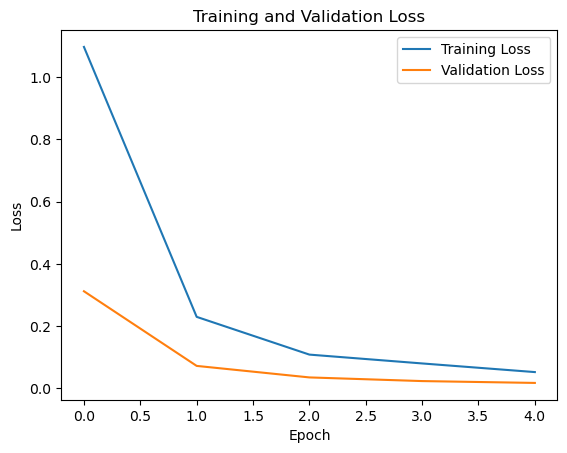

In [39]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


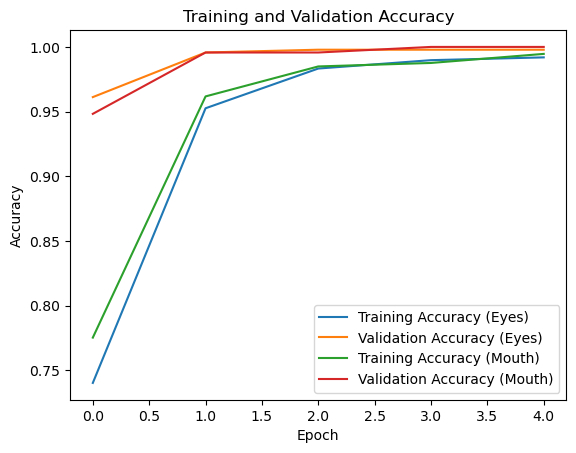

In [40]:
# Plot training and validation accuracy
plt.plot(model_history.history['eyes_output_accuracy'], label='Training Accuracy (Eyes)')
plt.plot(model_history.history['val_eyes_output_accuracy'], label='Validation Accuracy (Eyes)')
plt.plot(model_history.history['mouth_output_accuracy'], label='Training Accuracy (Mouth)')
plt.plot(model_history.history['val_mouth_output_accuracy'], label='Validation Accuracy (Mouth)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [43]:
# Assuming eye_X_test and mouth_X_test are your test data
eye_predictions, mouth_predictions = model.predict({'eye_input': eye_X_test, 'mouth_input': mouth_X_test})

# Convert one-hot encoded predictions back to class labels
eye_pred_labels = np.argmax(eye_predictions, axis=1)
mouth_pred_labels = np.argmax(mouth_predictions, axis=1)

# Get original class labels for test data
eye_true_labels = np.argmax(eye_y_test, axis=1)
mouth_true_labels = np.argmax(mouth_y_test, axis=1)

# Print classification report for eyes
print("Classification Report for Eyes:")
print(classification_report(eye_true_labels, eye_pred_labels))

# Print classification report for mouth
print("\nClassification Report for Mouth:")
print(classification_report(mouth_true_labels, mouth_pred_labels))



19/19 [==============================] - 48s 2s/step
Classification Report for Eyes:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       279
           1       1.00      1.00      1.00       301

    accuracy                           1.00       580
   macro avg       1.00      1.00      1.00       580
weighted avg       1.00      1.00      1.00       580


Classification Report for Mouth:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       301
           1       0.99      1.00      1.00       279

    accuracy                           1.00       580
   macro avg       1.00      1.00      1.00       580
weighted avg       1.00      1.00      1.00       580



In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Replace 'path_to_your_image.jpg' with the path to the image you want to test
user_image_path = 'C:\\Users\\yashu\\Downloads\\Desktop\\deep learning project\\test\\test 2.jfif'

# Load and preprocess the user-defined image
user_input = load_and_preprocess_image(user_image_path)

# Make predictions using the loaded model
predictions = model.predict({'eye_input': user_input, 'mouth_input': user_input})

# Extract prediction probabilities
eye_prediction_probabilities = predictions[0][0]
mouth_prediction_probabilities = predictions[1][0]

# Convert probabilities to class labels
eye_predicted_class = np.argmax(eye_prediction_probabilities)
mouth_predicted_class = np.argmax(mouth_prediction_probabilities)

# Print the predicted classes and probabilities
print(f'Predicted Class for Eyes: {eye_predicted_class}')
print(f'Probability for Eyes (Class {eye_predicted_class}): {eye_prediction_probabilities[eye_predicted_class]:.4f}')

print(f'Predicted Class for Mouth: {mouth_predicted_class}')
print(f'Probability for Mouth (Class {mouth_predicted_class}): {mouth_prediction_probabilities[mouth_predicted_class]:.4f}')


1/1 [==============================] - 5s 5s/step
Predicted Class for Eyes: 0
Probability for Eyes (Class 0): 0.8814
Predicted Class for Mouth: 0
Probability for Mouth (Class 0): 0.8142


19/19 [==============================] - 45s 2s/step


<Figure size 800x600 with 0 Axes>

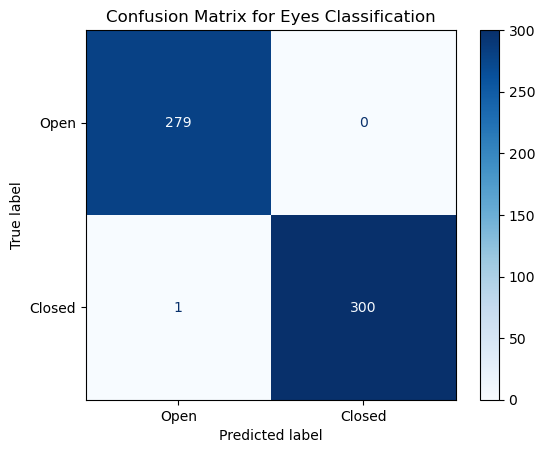

<Figure size 800x600 with 0 Axes>

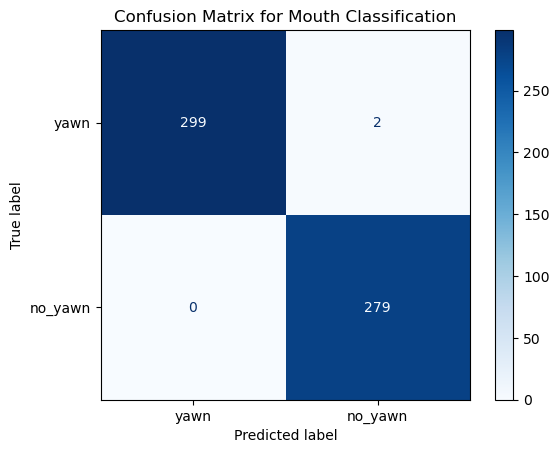

In [47]:
# Assuming eye_predictions and mouth_predictions are your model predictions

# Predict for eyes
eye_predictions = model.predict({'eye_input': eye_X_test, 'mouth_input': mouth_X_test})

# Predict for mouth
mouth_predictions = model.predict({'eye_input': eye_X_test, 'mouth_input': mouth_X_test})

# Extract the predicted labels (class with the highest probability)
eye_pred_labels = np.argmax(eye_predictions[0], axis=1)  # Access the first output in the list
mouth_pred_labels = np.argmax(mouth_predictions[1], axis=1)  # Access the second output in the list

# Compute confusion matrices
eye_cm = confusion_matrix(np.argmax(eye_y_test, axis=1), eye_pred_labels)
mouth_cm = confusion_matrix(np.argmax(mouth_y_test, axis=1), mouth_pred_labels)

# Plot confusion matrix for eyes
eye_labels = ['Open', 'Closed']
eye_display = ConfusionMatrixDisplay(confusion_matrix=eye_cm, display_labels=eye_labels)
plt.figure(figsize=(8, 6))
eye_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Eyes Classification')
plt.show()

# Plot confusion matrix for mouth
mouth_labels = ['yawn', 'no_yawn']
mouth_display = ConfusionMatrixDisplay(confusion_matrix=mouth_cm, display_labels=mouth_labels)
plt.figure(figsize=(8, 6))
mouth_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Mouth Classification')
plt.show()



In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Assuming eye_predictions and mouth_predictions are your model predictions

# Predict for eyes
eye_predictions = model.predict({'eye_input': eye_X_test, 'mouth_input': mouth_X_test})

# Access the first output in the list
eye_predictions_array = eye_predictions[0]

# Print the types and shapes of eye_y_test and eye_predictions_array
print(type(eye_y_test))
print(type(eye_predictions_array))
print(eye_y_test.shape)
print(eye_predictions_array.shape)

# Extract the predicted labels (class with the highest probability)
eye_pred_labels = np.argmax(eye_predictions_array, axis=1)
mouth_pred_labels = np.argmax(mouth_predictions[1], axis=1)

# ... (rest of the code remains unchanged)


19/19 [==============================] - 52s 3s/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(580, 2)
(580, 2)


19/19 [==============================] - 52s 3s/step


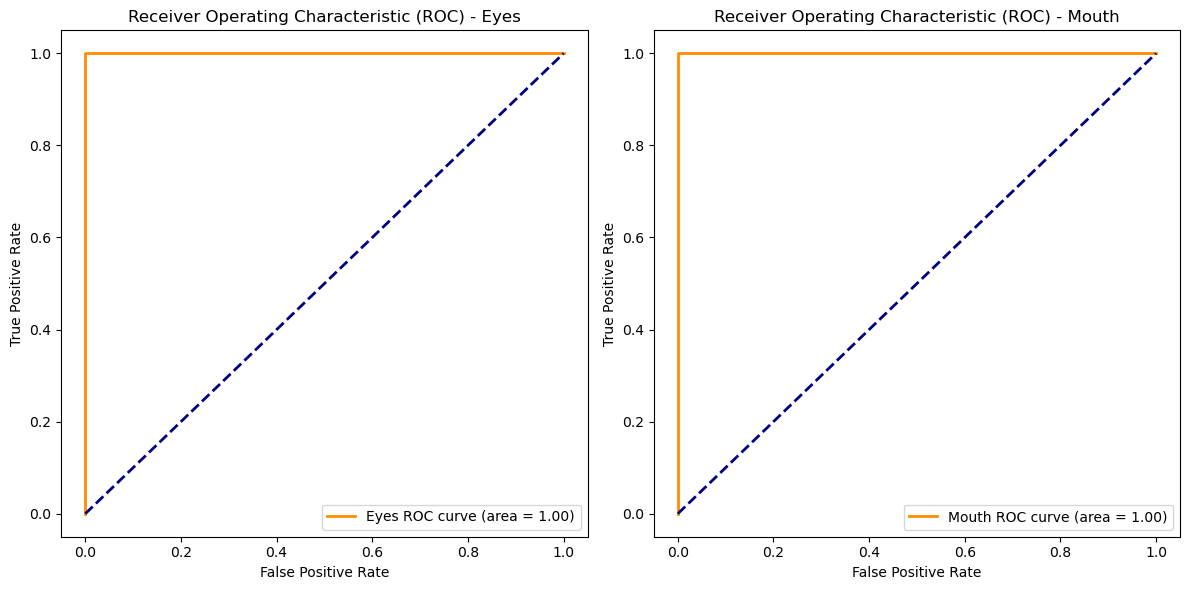

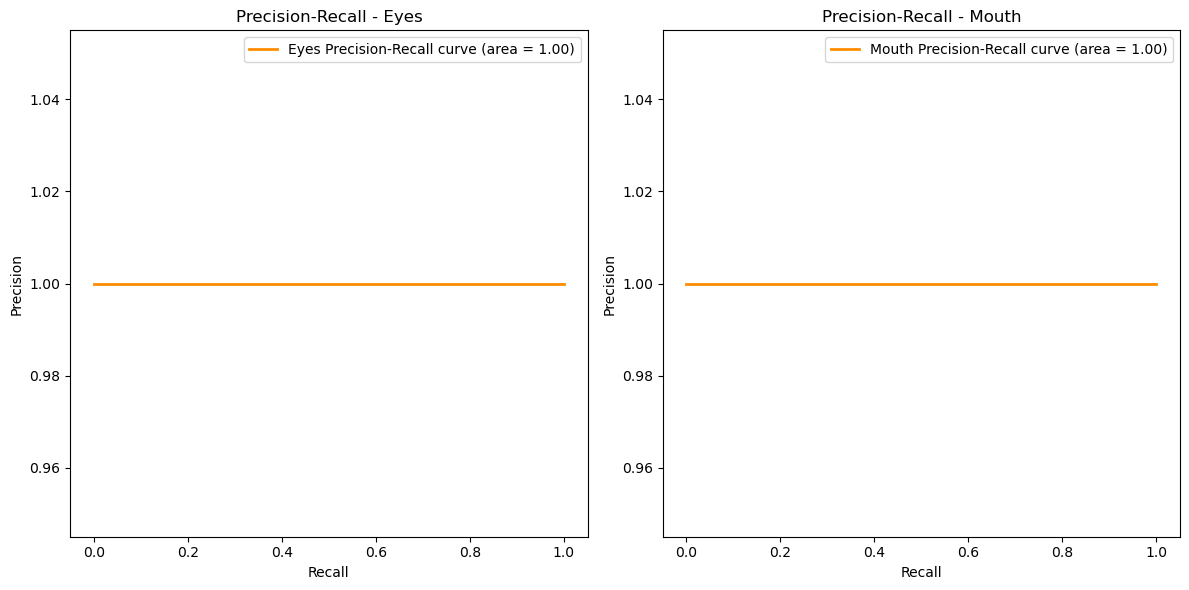

In [59]:
# Assuming eye_predictions_array and mouth_predictions_array are your model predictions
eye_predictions_array, mouth_predictions_array = model.predict({'eye_input': eye_X_test, 'mouth_input': mouth_X_test})

# Extract the predicted labels (class with the highest probability)
eye_pred_labels = np.argmax(eye_predictions_array, axis=1)
mouth_pred_labels = np.argmax(mouth_predictions_array, axis=1)

# Compute ROC and Precision-Recall curves for eyes
fpr_eye, tpr_eye, _ = roc_curve(eye_y_test[:, 1], eye_predictions_array[:, 1])  # Assuming the positive class is 1
roc_auc_eye = auc(fpr_eye, tpr_eye)
precision_eye, recall_eye, _ = precision_recall_curve(eye_y_test[:, 1], eye_predictions_array[:, 1])  # Assuming the positive class is 1
pr_auc_eye = auc(recall_eye, precision_eye)

# Compute ROC and Precision-Recall curves for mouth
fpr_mouth, tpr_mouth, _ = roc_curve(mouth_y_test[:, 1], mouth_predictions_array[:, 1])  # Assuming the positive class is 1
roc_auc_mouth = auc(fpr_mouth, tpr_mouth)
precision_mouth, recall_mouth, _ = precision_recall_curve(mouth_y_test[:, 1], mouth_predictions_array[:, 1])  # Assuming the positive class is 1
pr_auc_mouth = auc(recall_mouth, precision_mouth)

# Plot ROC curves for eyes and mouth
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_eye, tpr_eye, color='darkorange', lw=2, label=f'Eyes ROC curve (area = {roc_auc_eye:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Eyes')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_mouth, tpr_mouth, color='darkorange', lw=2, label=f'Mouth ROC curve (area = {roc_auc_mouth:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Mouth')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Plot Precision-Recall curves for eyes and mouth
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall_eye, precision_eye, color='darkorange', lw=2, label=f'Eyes Precision-Recall curve (area = {pr_auc_eye:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - Eyes')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(recall_mouth, precision_mouth, color='darkorange', lw=2, label=f'Mouth Precision-Recall curve (area = {pr_auc_mouth:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - Mouth')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def visualize_gradcam(model, layer_name, img_array):
    # Load and preprocess the image
    img_array = cv2.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Create a model that maps the input image to the activations of the specified layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Get the predictions for the input image
    with tf.GradientTape() as tape:
        intermediate_output = intermediate_layer_model(img_array)
        preds = model(img_array)
        top_pred_index = tf.argmax(preds[0])

    # Get the gradient of the top predicted class with respect to the output feature map of the specified layer
    grads = tape.gradient(preds[:, top_pred_index], intermediate_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by the gradient importance
    heatmap = tf.reduce_mean(intermediate_output * tf.expand_dims(pooled_grads, axis=0), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Upsample the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_array[0], 0.6, heatmap, 0.4, 0)

    # Display the original image, heatmap, and the superimposed image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f'{layer_name} Activation Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f'Superimposed Image with {layer_name} Heatmap')

    plt.show()

# Select a few test samples
sample_eye_images = eye_X_test[:3]
sample_mouth_images = mouth_X_test[:3]

# Visualize GradCAM for the first test sample
visualize_gradcam(model, 'efficientnetb0', sample_eye_images[0])
visualize_gradcam(model, 'efficientnetb0', sample_mouth_images[0])


UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define the class labels and their corresponding encoded labels
eye_labels = ['open', 'closed']
mouth_labels = ['yawn', 'no_yawn']

# Replace 'path_to_your_image.jpg' with the path to the image you want to test
user_image_path = 'C:\\Users\\yashu\\Downloads\\Desktop\\deep learning project\\test\\test 8.jpg'
# Load and preprocess the user-defined image
user_input = load_and_preprocess_image(user_image_path)

# Make predictions using the loaded model
predictions = model.predict({'eye_input': user_input, 'mouth_input': user_input})

# Extract predicted class labels (encoded)
eye_predicted_class_encoded = np.argmax(predictions[0])
mouth_predicted_class_encoded = np.argmax(predictions[1])

# Extract predicted class labels (original names)
eye_predicted_class = eye_labels[eye_predicted_class_encoded]
mouth_predicted_class = mouth_labels[mouth_predicted_class_encoded]

# Print the predicted class labels
print(f'Predicted Encoded Class for Eyes: {eye_predicted_class_encoded}')
print(f'Predicted Class for Eyes: {eye_predicted_class}')

print(f'Predicted Encoded Class for Mouth: {mouth_predicted_class_encoded}')
print(f'Predicted Class for Mouth: {mouth_predicted_class}')


1/1 [==============================] - 0s 141ms/step
Predicted Encoded Class for Eyes: 0
Predicted Class for Eyes: open
Predicted Encoded Class for Mouth: 1
Predicted Class for Mouth: no_yawn


In [10]:
pip install pydot


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


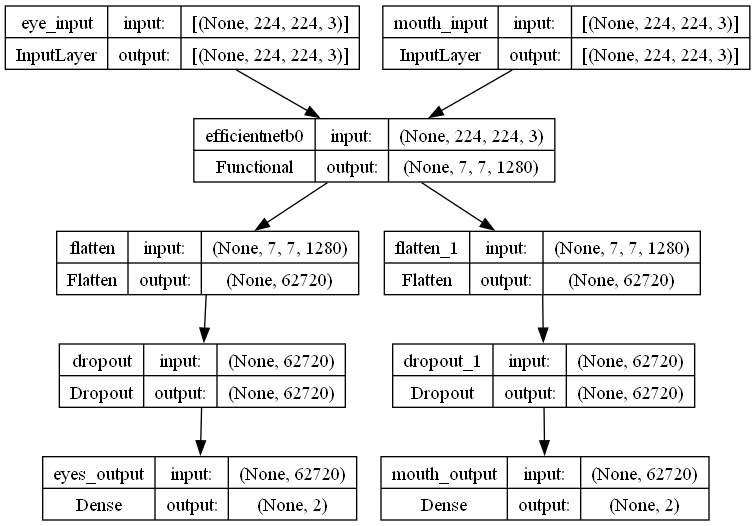

In [5]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture to a file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


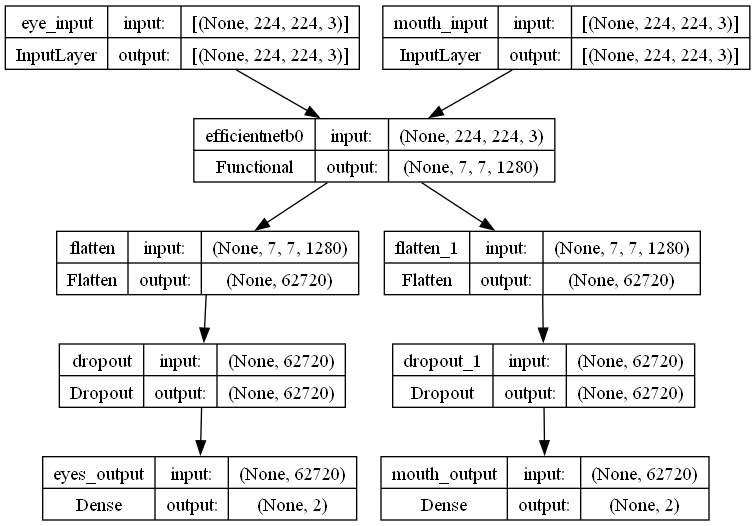

In [6]:
from tensorflow.keras.utils import plot_model
import pydot

# Load your trained model
trained_model = load_model('driver_drowsiness_model_multi_label_final.h5')  # Replace with the actual path

# Visualize the model architecture
plot_model(trained_model, to_file='trained_model_architecture.png', show_shapes=True)


In [15]:
model = load_model('driver_drowsiness_model_multi_label_final.h5')  # Replace with the actual path


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model

# Load your trained model



# Assuming 'model' is the final model with 'eye_input', 'mouth_input', 'eyes_output', and 'mouth_output'
# Change the layer names accordingly

# Function to visualize filters for a given layer
def visualize_filters(model, layer_name, input_data):
    intermediate_layer_model = model = Model(inputs=[eye_input, mouth_input], outputs=[eyes_output, mouth_output])
    # Choose an example image for visualization
    example_img = input_data[0]  # Assuming input_data is a list of eye images
    example_img = np.expand_dims(example_img, axis=0)
    example_img = preprocess_input(example_img)

    # Get the feature maps from the chosen layer for the example image
    feature_maps = intermediate_layer_model.predict(example_img)

    # Visualize the filters (assuming 8 filters for illustration)
    num_filters = min(8, feature_maps.shape[3])
    plt.figure(figsize=(15, 8))
    for i in range(num_filters):
        plt.subplot(num_filters // 4, 4, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.title(f'Filter {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize filters for the eye branch
visualize_filters(model, 'efficientnetb0', eye_X_train)

# Visualize filters for the mouth branch
visualize_filters(model, 'efficientnetb0', mouth_X_train)


ValueError: in user code:

    File "C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=uint8>]
